## Import

In [1]:
import numpy as np
import pandas as pd
from stateinterpreter import Classifier, identify_metastable_states, load_dataframe, descriptors_from_traj, sample
from stateinterpreter.plot import plot_states, plot_combination_states_features
#Paranoia
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')

## Preprocessing

Load trajectory

In [2]:
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
colvar_file = chignolin_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
stride = 100
#Load Collective Variables
colvar = load_dataframe(colvar_file, stride=stride).drop(['time'], axis=1)
#Compute descriptors
descriptors, feats_info = descriptors_from_traj(traj_dict, descriptors=['dihedrals','ca','hbonds_contacts'], stride=stride)

Computing CA distances
Computing Hydrogen bonds contacts
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (5248, 465)


Label states

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 4 local minima with selected populations:
	Basin 0 -> 955 configurations.
	Basin 1 -> 719 configurations.
	Basin 2 -> 673 configurations.
	Basin 3 -> 2364 configurations.


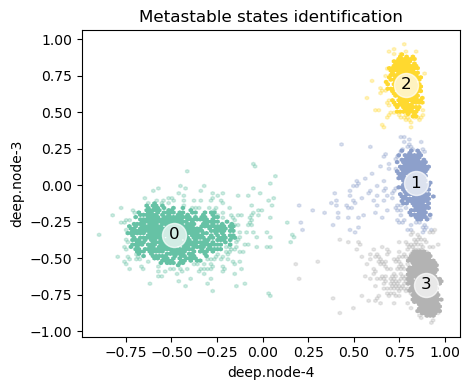

In [3]:
cv_list = ['deep.node-4', 'deep.node-3']
kBT = 2.8
states_labels = identify_metastable_states(colvar, cv_list, kBT, bw_method=0.07, optimizer_kwargs={'num_init' : 50})
plot_states(colvar, states_labels, cv_list, fes_isolines=False);

## Group lasso

A note on the problem to solve:
1. For regular Lasso $$ \min_{w}C\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \Vert w \Vert_{1}$$
2. For _group_ Lasso $$ \min_{w} \frac{1}{n}\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \lambda \sum_{j}  \Vert w_{j} \Vert_{2}$$

To have everything consistent $C \mapsto (\lambda n)^{-1}$. I'll use $\lambda$ as regularization parameter.

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


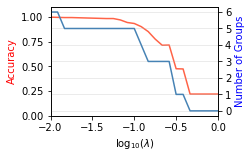

In [4]:
regularizers = np.geomspace(0.01, 1, 25)
select_feat = 'sin_|cos_'
states_names = [
    'Unfolded',
    'Folded Mid',
    'Folded High',
    'Folded Low'
]

sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, regex_filter = select_feat, states_names=states_names)
groups = [feats_info[name]['group'] for name in features_names]

classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, groups=groups)

classifier.plot();

In [5]:
reg = 10**(-1)
classifier.print_selected(reg)

Accuracy: 93%
State Unfolded:
[43.898%]  ASP3
[37.938%]  THR6
[17.428%]  THR8
[0.713% ]  TYR2
[0.023% ]  GLY7
State Folded Mid:
[46.599%]  THR6
[33.241%]  ASP3
[19.415%]  THR8
[0.723% ]  TYR2
[0.022% ]  GLY7
State Folded High:
[49.156%]  THR6
[48.742%]  THR8
[2.023% ]  ASP3
[0.044% ]  GLY7
[0.035% ]  TYR2
State Folded Low:
[53.35% ]  THR6
[41.083%]  THR8
[5.443% ]  ASP3
[0.096% ]  TYR2
[0.029% ]  GLY7


### Residue score (view & heatmap)

In [6]:
from stateinterpreter.io import load_trajectory
from stateinterpreter.visualize import compute_residue_score 

traj = load_trajectory(traj_dict, stride=stride)
# number of  residues
n_residues = traj.n_residues

residue_score = compute_residue_score(classifier,reg,feats_info,n_residues)

Visualize structure

In [7]:
from stateinterpreter.visualize import visualize_residue_score

visualize_residue_score(traj, states_labels, classes_names, residue_score, representation='licorice')

NGLWidget(max_frame=3)

Heatmap

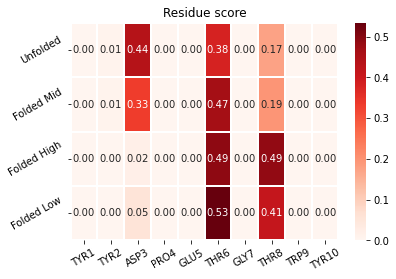

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get residue names
table, _ = traj.topology.to_dataframe()
residue_names = table["resName"] + table["resSeq"].astype("str")
residue_names = residue_names.unique()

# transform dictionary of residue scores into matrix and then into df to plot with seaborn (switch back to matplotlib?)
score_matrix = np.row_stack([score for score in residue_score.values()])
score_df = pd.DataFrame(score_matrix, columns = residue_names, index=states_names)

# Plot
sns.heatmap(score_df, annot=True, fmt=".2f", cmap='Reds', linewidths=2)

plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.title('Residue score')
plt.show()

## Standard Lasso

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:06<00:00,  3.67it/s]


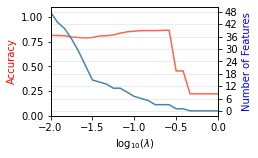

In [9]:
regularizers = np.geomspace(0.01, 1, 25)
select_feat = 'sin_|cos_'
states_names = [
    'Unfolded',
    'Folded Mid',
    'Folded High',
    'Folded Low'
]
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, regex_filter = select_feat, states_names=states_names)

classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000)

classifier.plot();

In [10]:
reg = 10**(-1)
classifier.print_selected(reg)

Accuracy: 85%
State Unfolded:
[99.683%]  SIDECHAIN cos_chi1 ASP3
[0.317% ]  SIDECHAIN cos_chi1 TYR2
State Folded Mid:
[100.0% ]  SIDECHAIN cos_chi1 ASP3
State Folded High:
[74.857%]  SIDECHAIN cos_chi1 THR8
[25.009%]  SIDECHAIN sin_chi1 THR6
[0.133% ]  BACKBONE sin_psi THR6
State Folded Low:
[73.884%]  SIDECHAIN sin_chi1 THR6
[12.398%]  SIDECHAIN cos_chi1 THR8
[10.941%]  SIDECHAIN cos_chi1 ASP3
[2.078% ]  SIDECHAIN sin_chi1 THR8
[0.7%   ]  BACKBONE sin_psi THR8


### Plot relevant features in CVs space

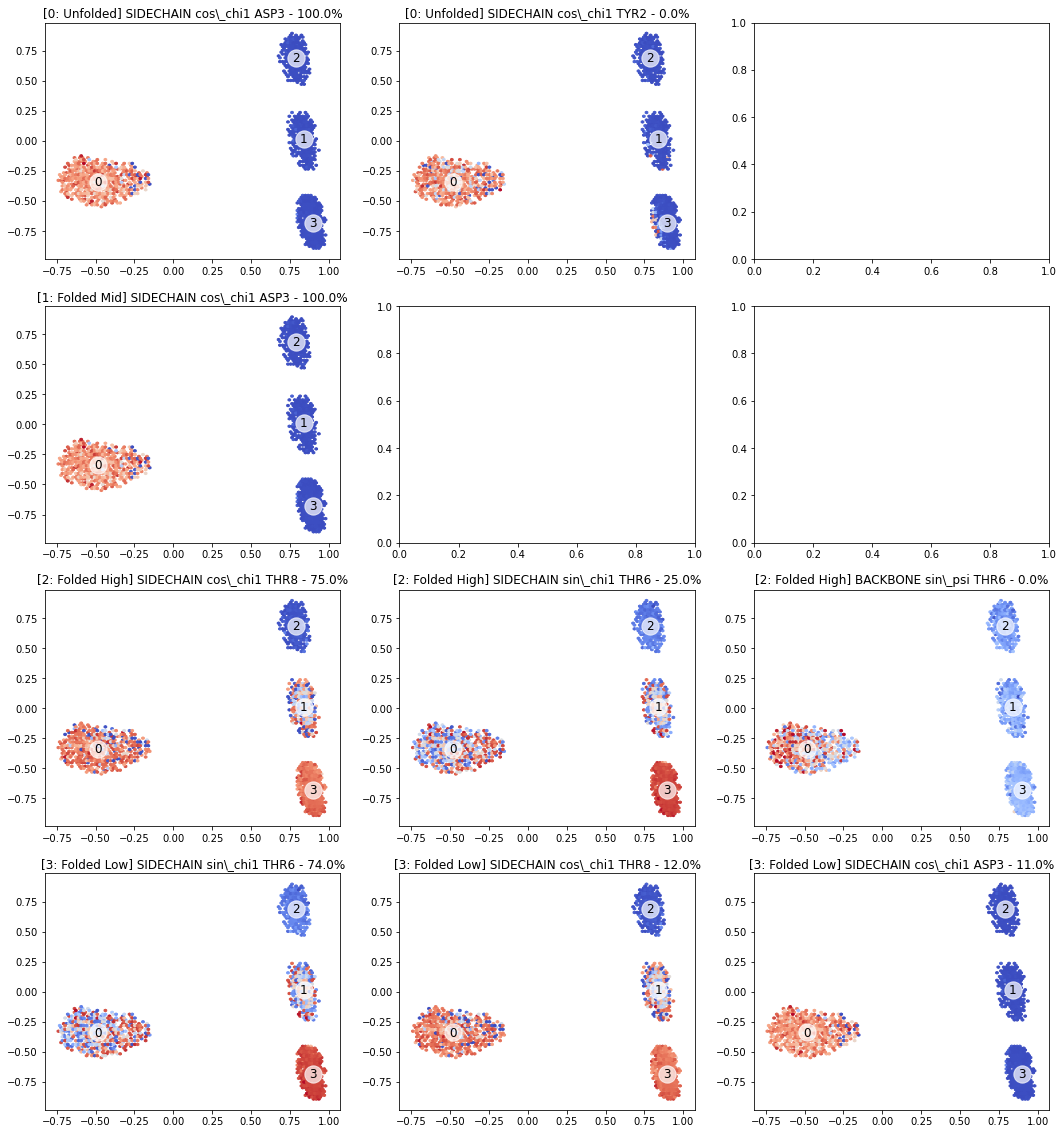

In [11]:
from stateinterpreter.plot import plot_combination_states_features

relevant_feat = classifier.feature_summary(reg)

plot_combination_states_features(colvar,descriptors,cv_list,relevant_feat,state_labels=states_labels)

### Visualize 3d structure

In [12]:
from stateinterpreter.visualize import visualize_features
from stateinterpreter.io import load_trajectory

traj = load_trajectory(traj_dict,stride=stride)
visualize_features(traj, states_labels, classes_names, relevant_feat, feats_info, state = 3, representation = 'licorice')

NGLWidget(max_frame=3)

### Histograms

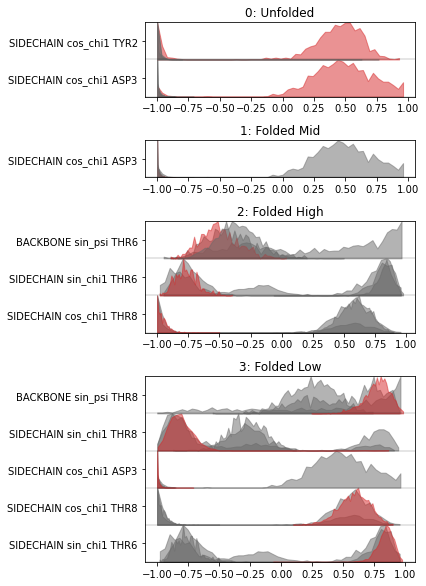

In [13]:
from stateinterpreter.plot import plot_histogram_features

plot_histogram_features(descriptors,states_labels,classes_names,relevant_feat)